# Clone my driving behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Lambda, Dropout, Cropping2D
from keras import backend as K
from livelossplot import PlotLossesKeras

/home/mariosk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
user = !whoami
user = user[0]

In [3]:
IMAGE_SHAPE = (160, 320, 3)
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'

## Load images and measurements

In [4]:
driving_log = (
    pd.read_csv(
        './my-videos/first_drives/driving_log.csv', 
        header=None,
        names=[
            'center_image', 'left_image', 'right_image', 
            'steering_angle', 'throttle', 'break', 'speed'])
    .assign(center_image=lambda df: PROJECT_DIR + "/my-videos/first_drives/" + df["center_image"].str.split("/").str[7:].str.join("/")))

In [5]:
%%time
raw_images = np.stack(driving_log['center_image'].map(plt.imread), axis=0)
flipped_images = np.flip(raw_images, axis=2)

images = np.vstack([raw_images, flipped_images]) 

CPU times: user 4.22 s, sys: 260 ms, total: 4.48 s
Wall time: 4.48 s


In [6]:
raw_measurements = driving_log['steering_angle']
measurements_flipped = - raw_measurements

measurements = np.hstack([raw_measurements, measurements_flipped])

## Define model

In [7]:
model = Sequential([
    Cropping2D(cropping=((70, 25), (0, 0)), input_shape=IMAGE_SHAPE),
    Lambda(lambda x: x / 255.0 - 0.5),
    Conv2D(20, (5, 5), activation='relu'),
    Conv2D(20, (5, 5), activation='relu'),
    MaxPooling2D(),
    Conv2D(50, (5, 5), activation='relu'),
    Conv2D(50, (5, 5), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(120),
    Dense(84),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam')

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 316, 20)       1520      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 312, 20)       10020     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 156, 20)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 152, 50)       25050     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 148, 50)       62550     
__________

## Train model

In [77]:
model.fit(
    images, 
    measurements, 
    epochs=1,
    validation_split=0.2, 
    shuffle=True)

Train on 2574 samples, validate on 644 samples
Epoch 1/1
  96/2574 [>.............................] - ETA: 5:46 - loss: 4.9346

KeyboardInterrupt: 

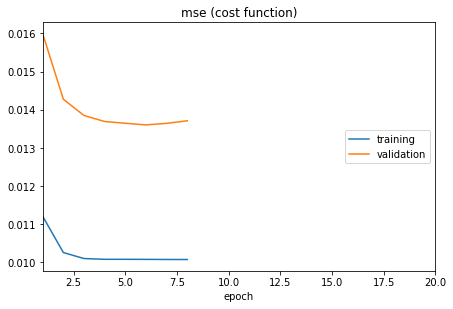

mse (cost function):
training   (min:    0.010, max:    0.011, cur:    0.010)
validation (min:    0.014, max:    0.016, cur:    0.014)
Epoch 9/20
1728/2574 [===================>..........] - ETA: 6s - loss: 0.0106

In [ ]:
model.fit(
    images, 
    measurements, 
    epochs=20,
    callbacks=[PlotLossesKeras()],
    validation_split=0.2, 
    shuffle=True)

In [12]:
model.save('./models/model_lenet_variant_cropped_images.h5a')

## Visualize output of convolution layers

In [9]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name or 'cropping2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

In [13]:
def plot_layer_channels(layer, name):
    number_of_channels = layer.shape[2]
    square_size = int(np.ceil(np.sqrt(number_of_channels)))

    fig, axes = plt.subplots(nrows=square_size, ncols=square_size, figsize=(20,20))
    for idx, image in enumerate(layer.transpose(2, 0, 1)):
        row = idx // square_size
        col = idx % square_size
        axes[row, col].axis('off')
        axes[row, col].imshow(image, cmap='gray', aspect='auto')

    for idx in [i for i in range(square_size ** 2) if i >= number_of_channels]:
        row = idx // square_size
        col = idx % square_size
        fig.delaxes(axes[row, col])
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle(f'Channels of layer {name}', fontsize=18)
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()

In [14]:
def plot_layers(input_image, evaluation_functions):
    layer_outputs = evaluation_functions([[input_image], 0.])
    
    plt.title('Input image')
    plt.imshow(input_image)
    plt.show()
    
    plt.title('Cropped image')
    plt.imshow(layer_outputs[0][0].astype('uint8'))
    plt.show()
    
    for layer, name in zip(layer_outputs[1:], layer_names):
        plot_layer_channels(layer[0], name)

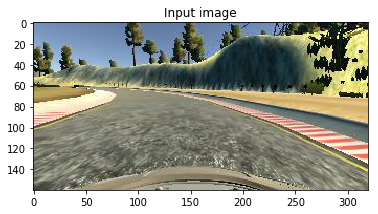

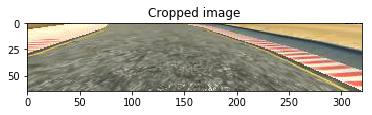

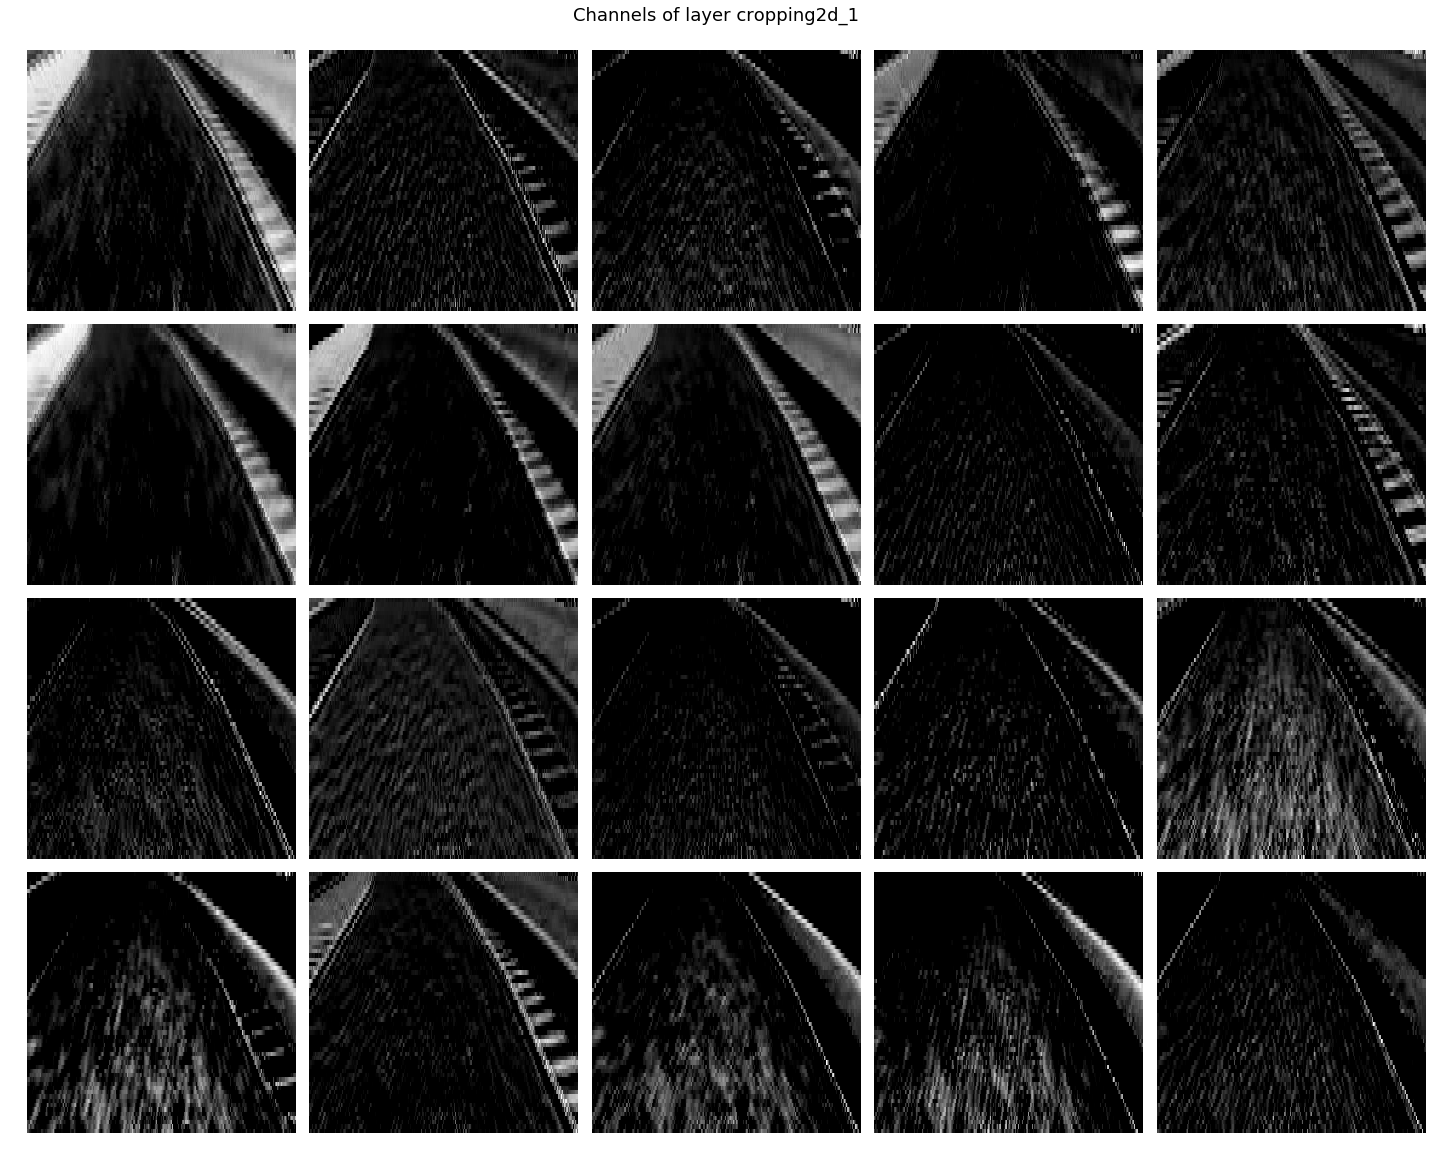

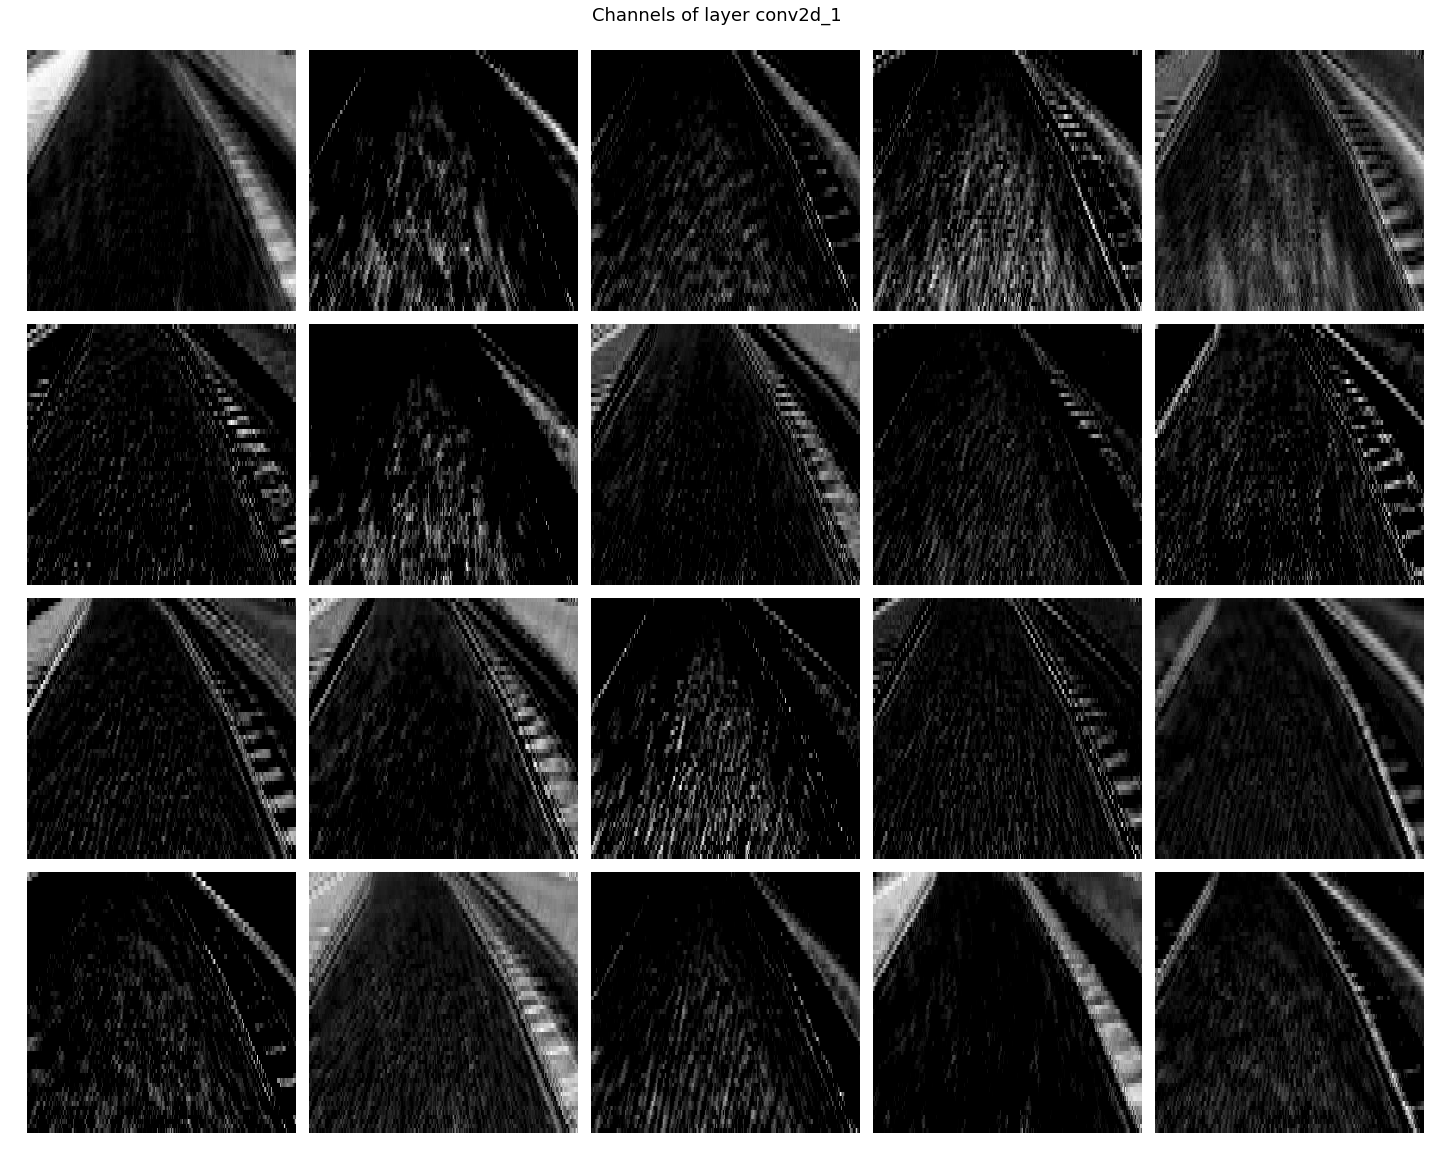

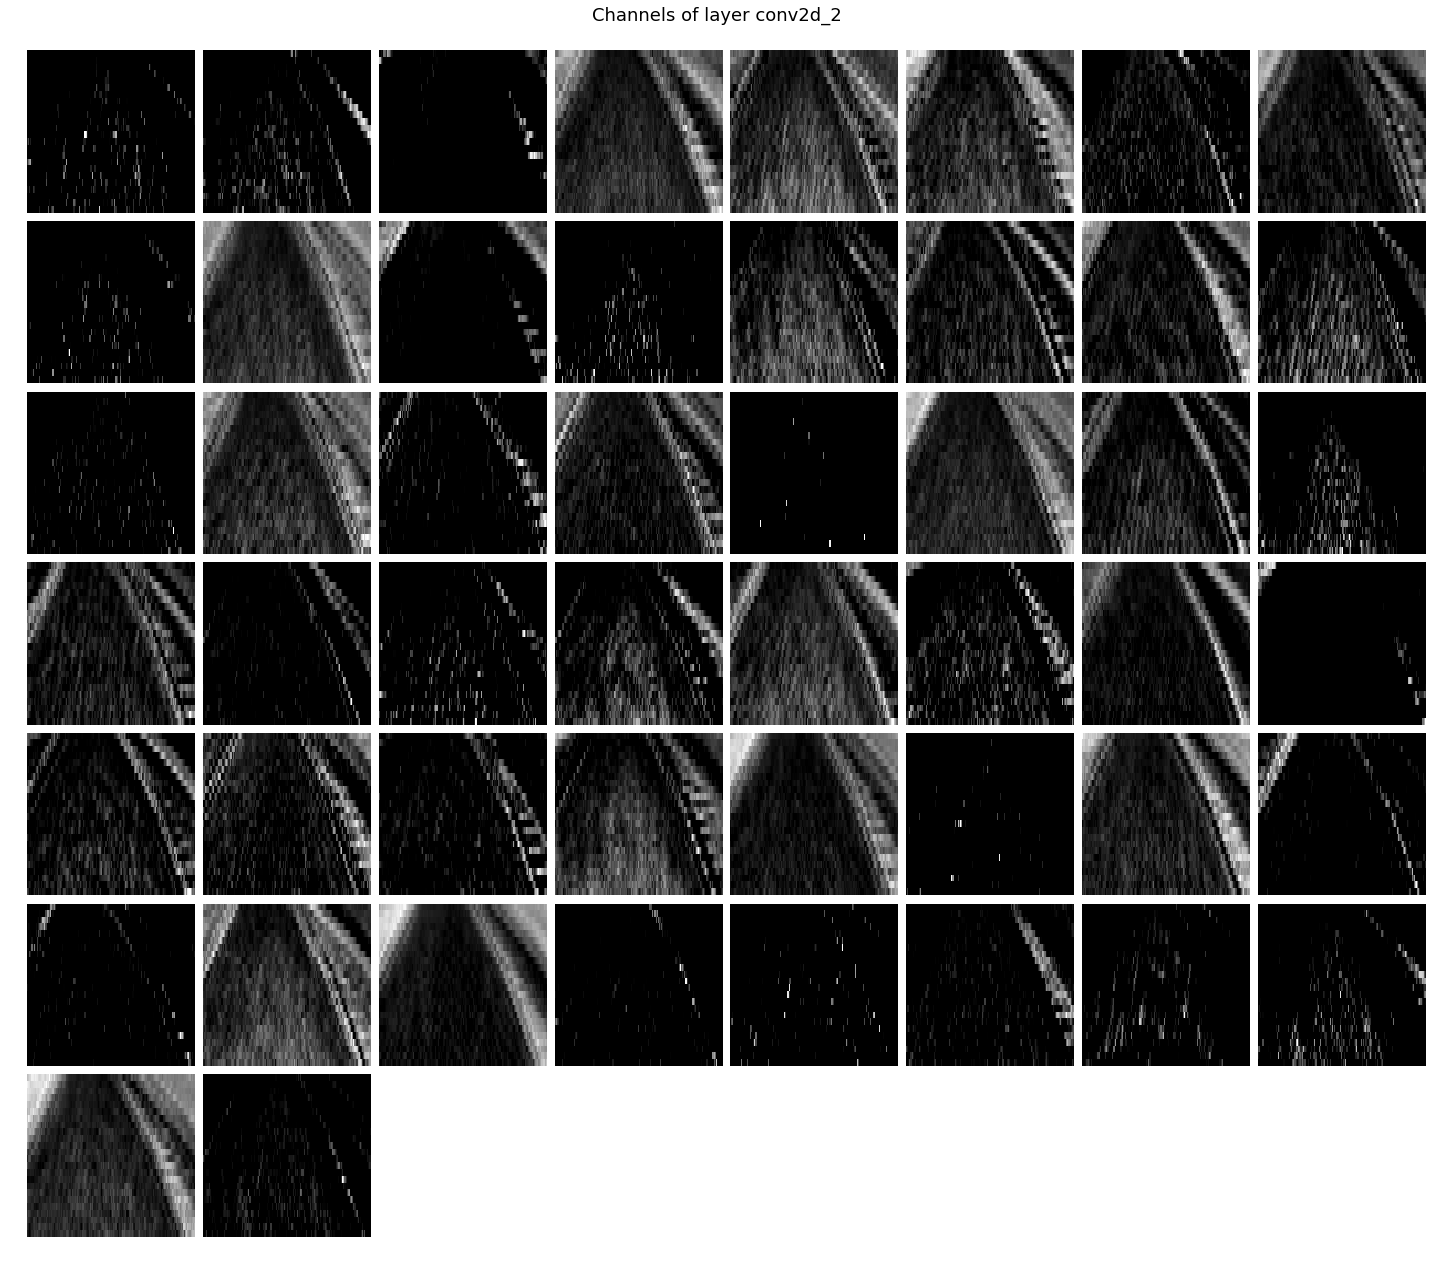

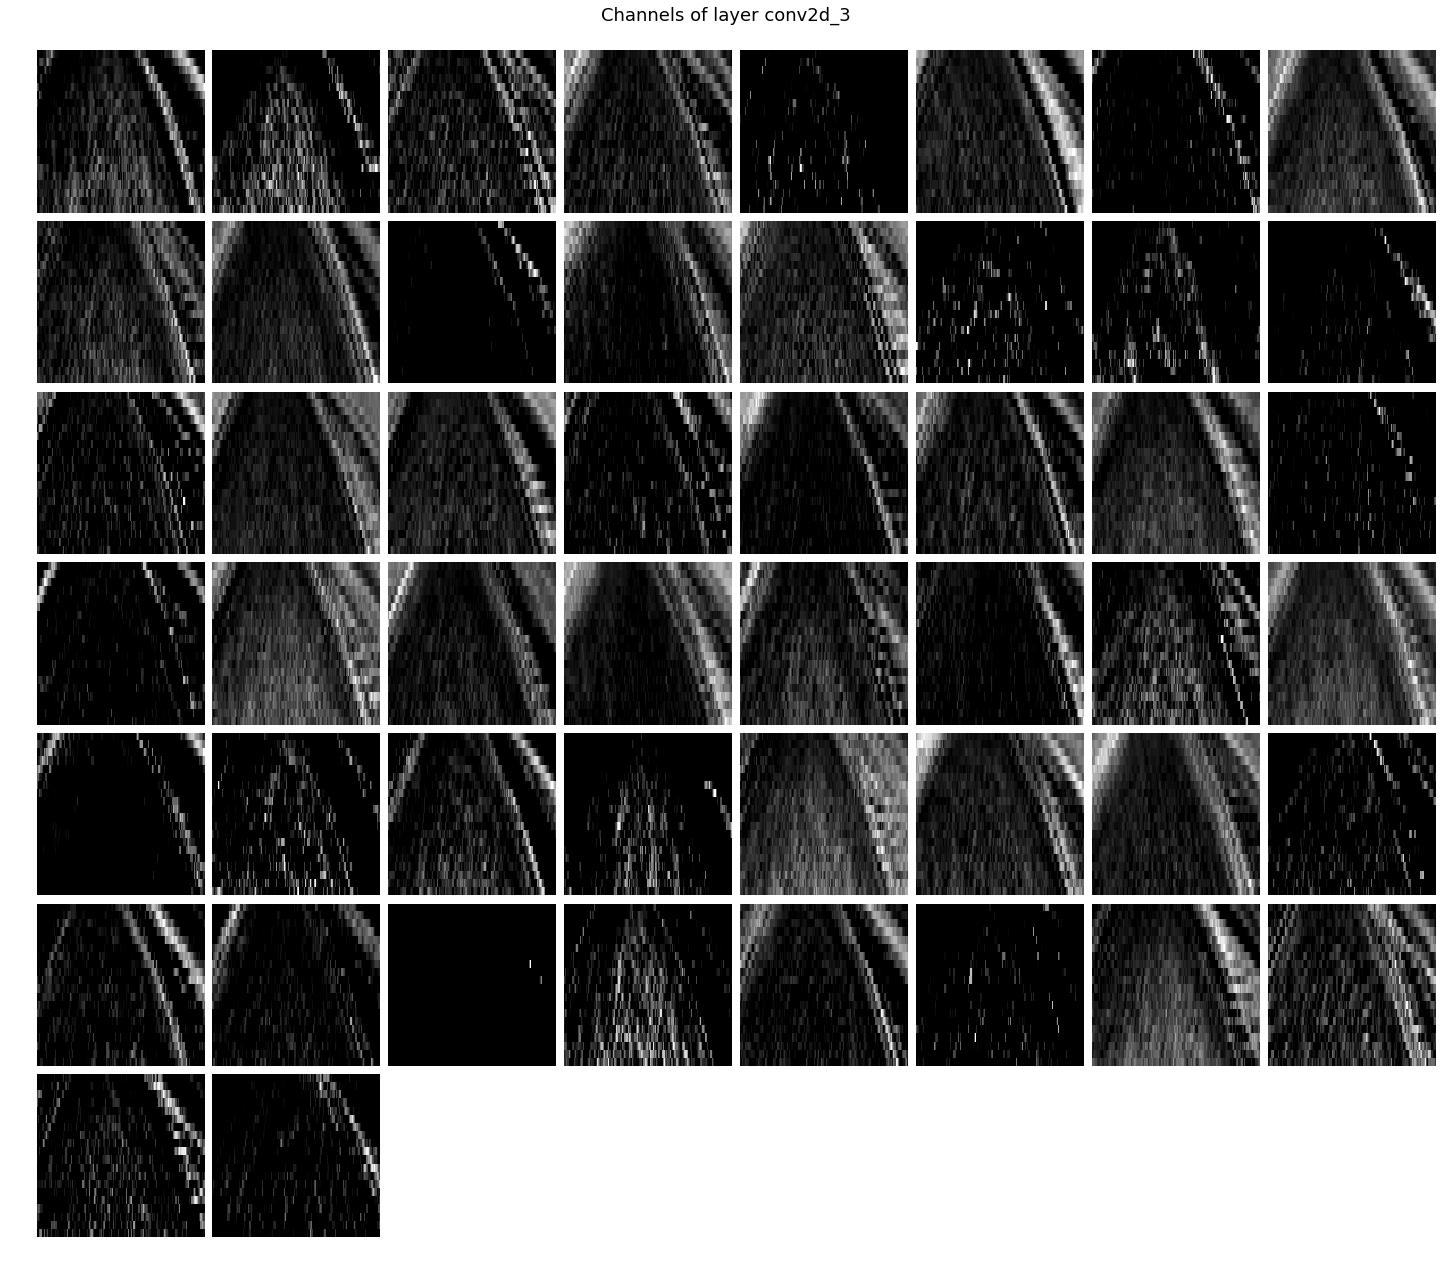

In [15]:
test_image = images[0]

plot_layers(test_image, evaluation_functions)